In [4]:
import numpy as np
import matplotlib.pyplot as plt

figure_width = 9
plt.rcParams['figure.figsize'] = [figure_width, figure_width * 3/8]
plt.rcParams['figure.dpi'] = 90
plt.rcParams['legend.fontsize'] = 'large'

# Linear ramps: $x_0$ to $x_1$ by Addition 

Linear envelope generators are a great place to start learning the ins and outs of real-time DSP coding. They're conceptually simple. If asked the right questions, most primary school students could pobably come up with the math that describes how to generate a linear ramp. Implementing the envelope generator is then a matter of translating that math to code that runs efficiently in real time and handles parameter changes gracefully. 

Below you'll find a (probably overly-formalized) derivation of the math and real time-appropriate prototype class of an ADSR envelope generator, written before translating to the C++ version you'll find in this repository.

## Derivation

If we initialize our envelope generator's value $x[0] = x_0$, and we want to be at value $x_1$ when we've rendered the $N^{th}$ sample $x[N-1] = x_1$, then the easiest way we can get there is by adding some precomputed value $d$ to $x$ each time we compute a sample. The value $d$ is just the slope of the line defined by the change in height over the change in length.

At any given sample $n$, the value of the envelope $x[n]$ will be

$$x[n] = x_0 + \sum_{i=1}^{n}{d}$$
.
$$x[n] = x_0 + dn$$

and knowing our endpoints $x_0$ and $x_1$, and the desired length $N$, we can solve for $d$

$$x_1 = x_0 + dN$$
\vspace
$$d = \frac{x_1-x_0}{N}$$

So if $x_1 > x_0$, then our ramp is increasing and the slope $d$ will be positive. If $x_1 < x_0$, then the ramp is decreasing and the slope will be negative. Easy peas, right? 

# Real Time

Using an object-oriented approach, we can now write an envelope generator that is capable of rendering samples in real time, meaning it needs to efficiently

1. Compute and return the next sample
1. Maintain a state for each ramp
1. Implement logic for switching states between `attack`, `decay`, `sustain`, `release`, and `idle`
1. Modify the duration of each ramp&mdash;including any time during the ramp we're modifying

Moreover, we can't assume states always last their specified duration. If we're controlling this thing from a keyboard, we might release the key before the attack state is complete, or we might release during the decay state, or retrigger an attack before the release state is complete. This means that when we compute our ramp, we should set the initial level $x_0$ to whatever the current level $x$ is.

### Discrete Time

This code has to be able to run at different rates dictated by some sample rate parameter $f_s$, so we'll now be dealing in normalized discrete time. Any time we need to set the duration of a ramp in seconds, we can convert it to samples using the sample rate

$$L = T \cdot f_s$$
 
$$(samples) = (sec) \cdot \left(\frac{samples}{sec}\right)$$

That also means the time resolution of our ramps is dictated by the sample rate, so if we're running at $48kHz$, our time resolution is about $20.8\mu s$.

### State Machine

The underlying implementation will be a state machine. While in states `attack`, `decay`, or `release`, the envelope generator will return samples from a ramp from $x_0$ to $x_1$ over a specified length. Otherwise, the envelope generator has less work to do, as it only needs to return the sustain level $x_{sus}$ for `sustain`, or $0$ for `idle`.

A lot of implementations are designed to change state when $x$ reaches a desired threshold, so if we're attacking for example, we might transition to decay when $x \geq 1$. Here, we're instead opting to use a phase accumulator, which starts at $0$, increments each time we compute a sample, then we transition to the next state when we've computed the desired number of samples. This adds an additonal cost of incrementing the phase, but lends well to extending or truncating ramps if the length changes while we're in that state, since we can easily account for the time already spent in the state.

### Rendering Samples

In a real-time context, we don't really need to know what every value in the ramp will be. We only really need to know how to get from the current level to the next. We'll have some method `render()`, which computes and returns a single sample of the ramp. The core of what that method needs to do is just add the slope $d$ to the current value $x$

$$x := x + d$$

assuming we've precomputed the slope $d$ when we set the length of the ramp. Then we just increment the phase, and handle the state transition if we've completed the ramp.

### Initializing a Ramp

The implementation below recomputes the slope every time we initialize a ramp, which happens if we're transitioning to a new state, or recomputing the ramp mid-state. This gives us an easy way of always ramping from the current level. 

Though our render method only knows about current values for the level $x$, slope $d$, phase, and length, we do store separate length variables for `a/d/r`. This way, we can set the length of a state at any time, and then compute the slope when the state begins.

The only other thing we need to do is reset the phase to zero, and set the length where we'll transiton to the next state.

### Testing
To understand how this class works, I'd recommend starting with the `__init__()` and `render()` methods and tracing the function calls, then see how parameter changes are handled by tracing through the other interface methods.

Below, we test the envelope generator by rendering 1.4 seconds worth of samples, and gating it on after 200 milliseconds. You can verify correct implementation of mid-ramp length readjustment by inserting parameter changes in a similar way. 

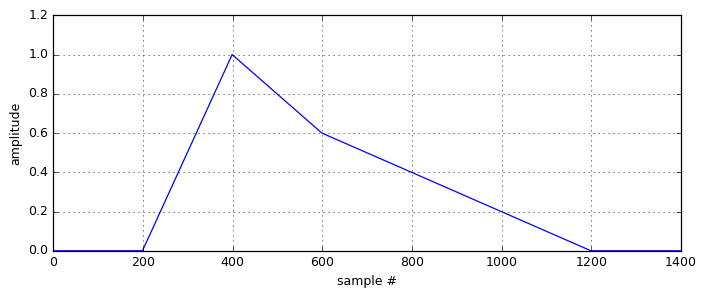

In [31]:
import numpy as np
import matplotlib.pyplot as plt

class ADSR:
    
    def __init__(self, atk_len, dec_len, sus_level, rel_len):
        self.__begin_idle()       # Initialize to idle state
        self.atk_len = atk_len    # Number of samples in attack state
        self.dec_len = dec_len    # Number of samples in decay state
        self.rel_len = rel_len    # Number of samples in release state
        self.x_sus = sus_level    # Level of sustain state
        self.sustain = False      # Decay -> Sustain, or Decay -> Release
        self.retrigger = False    # Release -> Attack, or Release -> Idle
    
    def __init_ramp(self, x0, x1, length):
        self.slope = (x1 - x0) / length
        self.length = length
        self.phase = 0  
         
    def __begin_attack(self):
        self.state = 'attack'
        self.__init_ramp(self.x, 1, self.atk_len)
        
    def __begin_decay(self):
        self.state = 'decay'
        self.__init_ramp(self.x, self.x_sus, self.dec_len)
        
    def __begin_sustain(self):
        self.state = 'sustain'
        self.x = self.x_sus
        
    def __begin_release(self):
        self.state = 'release'
        self.__init_ramp(self.x, 0, self.rel_len)
        
    def __begin_idle(self):
        self.state = 'idle'
        self.x = 0
        
    def __next_state(self):
        if self.state == 'attack':
            self.__begin_decay()
        elif self.state == 'decay':
            if self.sustain:
                self.__begin_sustain()
            else:
                self.__begin_release()
        elif self.state == 'release':
            if self.retrigger:
                self.__begin_attack()
            else:
                self.__begin_idle()
        
    # == Interface:
    def set_attack_length(self, length):
        self.atk_len = length
        if self.state == 'attack':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.x, 1, length)
            
    def set_decay_length(self, length):
        self.dec_len = length
        if self.state == 'decay':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.x, self.x_sus, length)
            
    def set_sustain_level(self, level):
        self.x_sus = level
        if self.state == 'decay':
            length = self.dec_len - self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.x, self.x_sus, length)
    
    def set_release_length(self, length):
        self.rel_len = length
        if self.state == 'release':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.x, 0, length)
            
    def gate(self, is_high):
        if is_high:
            self.__begin_attack()
        else:
            self.__begin_release()
    
    def render(self):
        if self.state == 'idle' or self.state == 'sustain':
            return self.x
        self.x += self.slope               # Add the slope to the current value
        self.phase += 1                    # Increment the phase
        if self.phase >= self.length:      # Check for end of state
            self.__next_state()
        return self.x

fs = 1000      # Sample rate (samples/sec)

# Instantiate the generator and set state lengths
adsr = ADSR(int(0.2 * fs),    # Attack length
            int(0.2 * fs),    # Decay length
            0.6,              # Sustain level
            int(0.6 * fs))    # Release length

# Render 1.4 seconds of samples, and save for plotting
x_env = np.zeros(int(1.4 * fs)) 
for n in range(len(x_env)): 
    
    # Gate on after 0.2 seconds
    if n == int(0.2 * fs):    
        adsr.gate(True)
        
    # Try inserting parameter changes to verify modification
    # of ramp lengths mid-state
#     if n == int(0.3 * fs):
#         adsr.set_attack_length(0.4 * fs)
    
    x_env[n] = adsr.render()      # Render
    
    # Uncomment to verify the exact values generated
#     print('state = %s, level = %f' % (adsr.state, x_env[n]))
    
plt.plot(x_env)
plt.xlabel("sample #")
plt.ylabel("amplitude")
plt.ylim((0, 1.2))
plt.grid(True)
plt.show()